In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/vision3.zip -d /content/brain-tumor
!unzip /content/drive/MyDrive/vision.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/g

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [ ]:
np.random.seed(42)

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [ ]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

model = unet((256,256,3))
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")

In [ ]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
batch_size = 16
lr = 1e-4
num_epochs = 100
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")
dataset_path="/content/brain-tumor"

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: ({len(train_x)},{len(train_y)})")
print(f"Valid: ({len(valid_x)},{len(valid_x)})")
print(f"Test: ({len(test_x)},{len(test_x)})")

Train: (1840,1840)
Valid: (612,612)
Test: (612,612)


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [ ]:
model = unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,'accuracy'])

In [ ]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

In [ ]:
model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=1,
    )

Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 0.8639 - dice_coef: 0.1361 - accuracy: 0.8338
Epoch 1: val_loss improved from inf to 0.95118, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/115 [==============================] - 169s 1s/step - loss: 0.8639 - dice_coef: 0.1361 - accuracy: 0.8338 - val_loss: 0.9512 - val_dice_coef: 0.0487 - val_accuracy: 0.4174 - lr: 1.0000e-04
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.7469 - dice_coef: 0.2531 - accuracy: 0.9708
Epoch 2: val_loss did not improve from 0.95118
115/115 [==============================] - 106s 925ms/step - loss: 0.7469 - dice_coef: 0.2531 - accuracy: 0.9708 - val_loss: 0.9813 - val_dice_coef: 0.0186 - val_accuracy: 0.5538 - lr: 1.0000e-04
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.6671 - dice_coef: 0.3329 - accuracy: 0.9804
Epoch 3: val_loss did not improve from 0.95118
115/115 [==============================] - 116s 1s/step - loss: 0.6671 - dice_coef: 0.3329 - accuracy: 0.9804 - val_loss: 0.9625 - val_dice_coef: 0.0373 - val_accuracy: 0.8882 - lr: 1.0000e-04
Epoch 4/100
115/115 [==============================] - ETA: 0s - loss: 0.5788 - dice_coef:

In [ ]:
import pandas as pd
metrics = pd.read_csv("/content/files/log.csv")
metrics.head(2)

,epoch,accuracy,dice_coef,loss,lr,val_accuracy,val_dice_coef,val_loss
0,0,0.833832,0.136139,0.863861,0.0001,0.417428,0.048719,0.951181
1,1,0.970794,0.253060,0.746940,0.0001,0.553820,0.018641,0.981283


<Axes: >

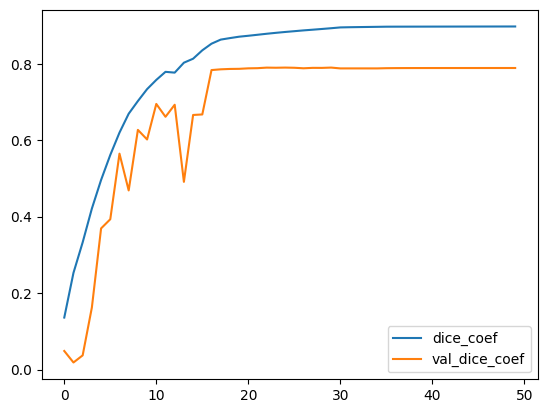

In [ ]:
metrics[['dice_coef','val_dice_coef']].plot()

<Axes: >

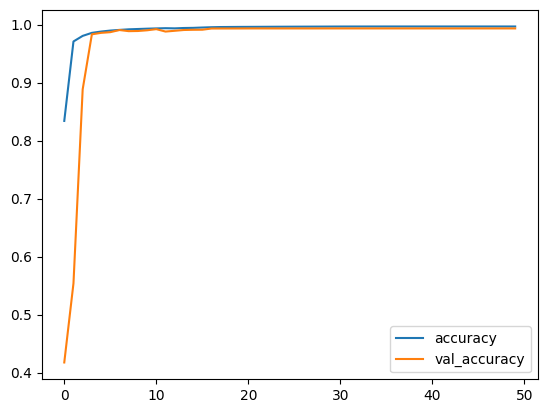

In [ ]:
metrics[['accuracy','val_accuracy']].plot()

<Axes: >

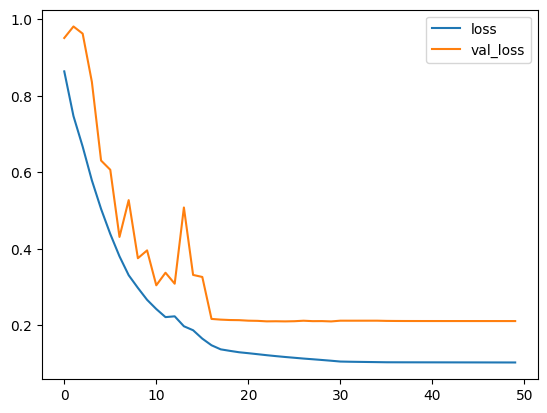

In [ ]:
metrics[['loss','val_loss']].plot()

In [ ]:
create_dir("results")

# with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
#     model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

In [ ]:
from tqdm import tqdm
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [ ]:
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    """ Flatten the array """
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv", index=None)

100%|██████████| 612/612 [02:06<00:00,  4.83it/s]

F1: 0.74178
Jaccard: 0.65724
Recall: 0.73362
Precision: 0.80577


In [ ]:
scores = pd.read_csv("/content/files/score.csv")
scores.head(3)

,Image,F1,Jaccard,Recall,Precision
0,833.png,0.938667,0.884422,0.929577,0.947935
1,2069.png,0.846847,0.734375,1.000000,0.734375
2,3038.png,0.657426,0.489676,0.775701,0.570447


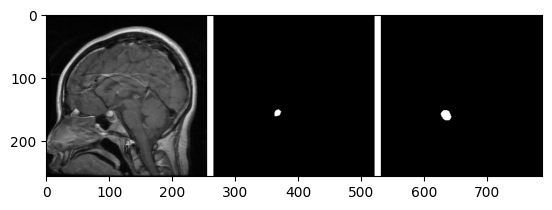

In [ ]:
dir = "/content/results/"
images = os.listdir("/content/results")[:5]
img1 = plt.imread(dir+images[0])
plt.imshow(img1, cmap='gray')

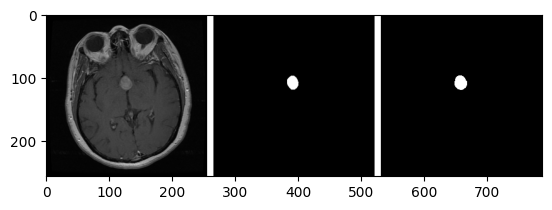

In [ ]:
img1 = plt.imread(dir+images[1])
plt.imshow(img1, cmap='gray')

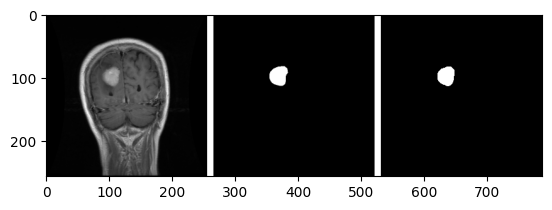

In [ ]:
img1 = plt.imread(dir+images[2])
plt.imshow(img1, cmap='gray')

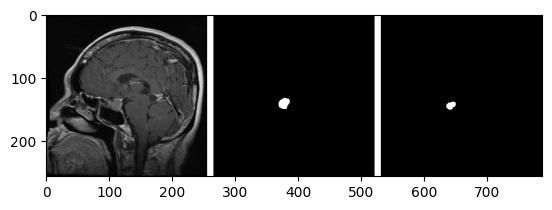

In [ ]:
img1 = plt.imread(dir+images[3])
plt.imshow(img1, cmap='gray')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define the dice_coef function
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Register the custom loss and metric functions
with tf.keras.utils.custom_object_scope({'dice_loss': dice_loss, 'dice_coef': dice_coef}):
    model1 = load_model('/content/drive/MyDrive/model_Unet.h5')

(216, 234, 3)


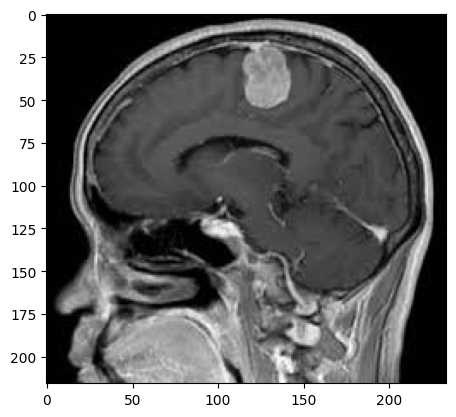

In [ ]:
import cv2
img = cv2.imread('/content/Testing/meningioma/Te-me_0056.jpg')
print(img.shape)
plt.imshow(img)

(216, 234)


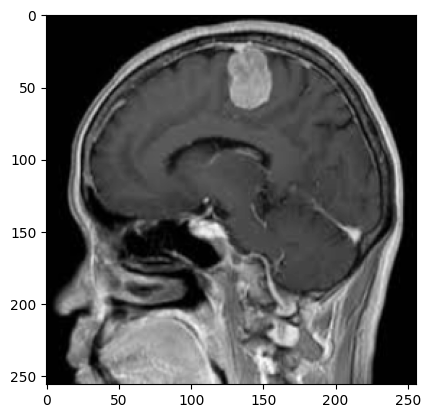

In [ ]:
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_new = cv2.resize(gray_img, (256,256))
print(gray_img.shape)
plt.imshow(img_new,cmap = 'gray')

In [ ]:
# import numpy as np

# Normalize your image data
img_scaled = img_new / 255

# Add batch and channel dimensions
img_scaled = np.expand_dims(img_scaled, axis=0)  # Batch dimension
img_scaled = np.expand_dims(img_scaled, axis=-1)  # Single channel dimension

# Repeat the single channel across three channels (for RGB)
img_scaled = np.repeat(img_scaled, 3, axis=-1)  # Repeat along the last axis

print(img_scaled.shape)  # Verify the shape before passing it to the model
y_pred = model1.predict(img_scaled)
y_pred = np.squeeze(y_pred, axis=-1)
y_pred = y_pred >= 0.5
y_pred = y_pred.astype(np.int32)
print(y_pred)



(1, 256, 256, 3)
1/1 [==============================] - 0s 21ms/step
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


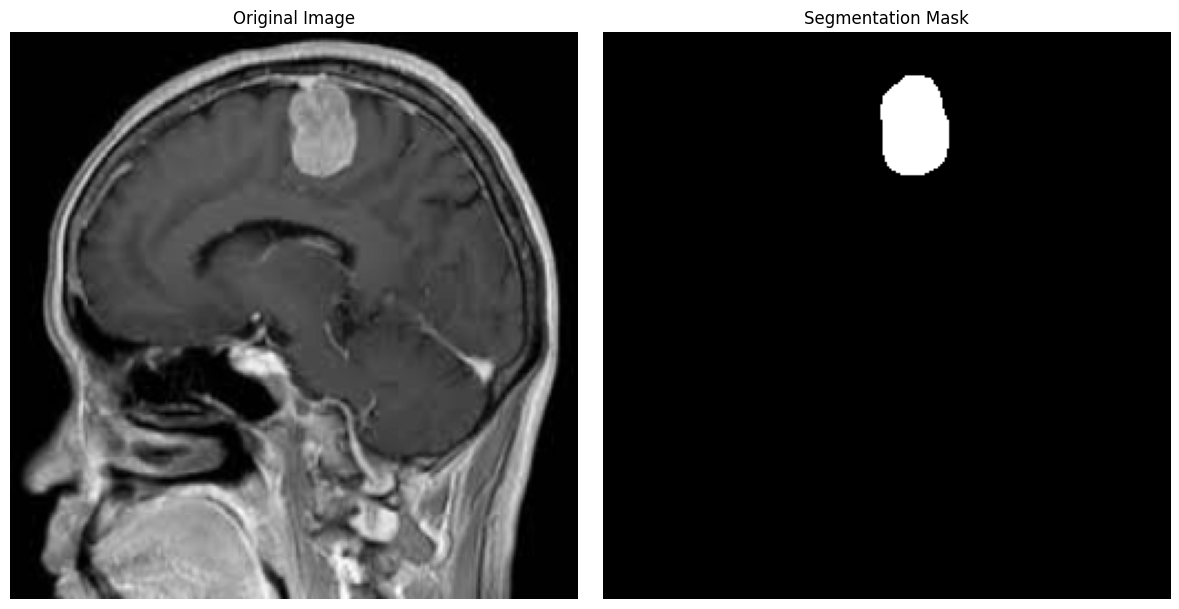

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_hat contains the predicted segmentation mask
# Ensure the predicted mask is in a suitable format for visualization (e.g., probability scores or classes)

# Choose the first sample from the batch (assuming batch size is 1)
predicted_mask = y_pred[0]

# Assuming the output is a probability mask and you want to threshold it
threshold = 0.5  # You can adjust this threshold as needed
binary_mask = (predicted_mask > threshold).astype(np.uint8)

plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(img_new,cmap = 'gray')
plt.title('Original Image')
plt.axis('off')

# Display segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap='gray')  # Assuming binary mask
plt.title('Segmentation Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

# # Visualize the predicted segmentation mask
# plt.imshow(binary_mask.squeeze(), cmap='gray')  # Squeeze to remove the batch dimension if present
# plt.title('Predicted Segmentation Mask')
# plt.axis('off')
# plt.colorbar()  # Add a colorbar if needed
# plt.show()

In [ ]:
import cv2

# Tìm contours trong binary mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Tính toán diện tích của các contours
area = 0
for contour in contours:
    area += cv2.contourArea(contour)

resolution = 100  # Ví dụ: 100 pixel/cm

# Chuyển đổi diện tích từ pixel sang cm²
area_cm2 = area / (resolution ** 2)
print(f"Diện tích của vùng được segment là: {area_cm2} cm²")

print(f"Diện tích của vùng được segment là: {area} pixels")

Diện tích của vùng được segment là: 0.1091 cm²
Diện tích của vùng được segment là: 1091.0 pixels


In [ ]:
from matplotlib import image as mpimg

# Lưu ảnh binary_mask vào một thư mục
output_folder = 'segmentation_results'
os.makedirs(output_folder, exist_ok=True)
output_filename = 'binary_mask.png'
mpimg.imsave(os.path.join(output_folder, output_filename), binary_mask, cmap='gray')
